In [116]:
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch import nn
import torch.nn.functional as F
import torch
from torch.optim import Adam

from torch import cuda

import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
from tqdm import tqdm
import os

In [117]:
### Parameters
batch_size = 64
crop_size = 256
image_size = 102

save_t01 = False
load_t01 = True

save_t02 = False
load_t02 = False

if cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

### Hyperparams
learning_rate = 0.002
betas = (0.9, 0.999)

In [118]:
class GZ2Dataset(Dataset):
    def __init__(self, csv_file_maps: str, csv_file_data: str, root_dir: str, transform = None) -> None:
        """
        Initializes the dataset.

        Parameters:
            csv_file_maps (str): Name of *.csv file that contains the filename to id mapping for the images
            csv_file_data (str): Name of *.csv file that contains the labeled data for every id
            root_dir (str): Directory containing all the images
            transform (class from torchvision.transforms): Transform to be used on the image data
        """
        self.maps = pd.read_csv(csv_file_maps)
        self.data = pd.read_csv(csv_file_data)[:-20000][:10000] # Reserve last 20000 elements for testing
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        """
        Returns the size of the dataset as number of elements.

        Returns:
            int: Number of elements
        """
        return len(self.data)
    
    def __getitem__(self, index: int) -> tuple:
        """
        Returns an element from the dataset for a given index.

        Parameters:
            index (int): The index of the element to be returned

        Returns:
            tuple: Tuple in the form of (image_data: torch.Tensor, datapoint_1, datapoint_2, ...)

        """
        # Value of the "dr7objid" field for the current element
        dr7objid = self.data['dr7objid'][index]

        filename = str(self.maps[self.maps['objid'] == dr7objid]['asset_id'].item()) + '.jpg'
        image_path = os.path.join(self.root_dir, filename)
        image = io.imread(image_path) # Load image as numpy tensor with normalized color values

        # pandas Dataframe containing all the datapoints for the given dr7objid
        image_data = self.data.loc[self.data['dr7objid'] == dr7objid]

        # Select prediction (for t01) from maximum percentage of votes 
        predictions_t01 = [image_data.to_numpy()[0][13], image_data.to_numpy()[0][19], image_data.to_numpy()[0][25]]
        prediction_t01 = predictions_t01.index(max(predictions_t01))

        predictions_t02 = [image_data.to_numpy()[0][31], image_data.to_numpy()[0][37]]
        prediction_t02 = predictions_t02.index(max(predictions_t02))

        # Possible predictions:
        # 0:= smooth
        # 1:= features
        # 2:= star

        if self.transform:
            image = self.transform(image)

        output = tuple([image.to(device), torch.tensor(prediction_t01).to(device), torch.tensor(prediction_t02).to(device)])#, torch.tensor(predictions).to(device)])

        return output

In [119]:
transform = transforms.Compose([transforms.ToTensor(), transforms.RandomRotation(degrees=(0,180)), transforms.CenterCrop(crop_size), transforms.Resize(image_size)]) # Transforms to be used on the data

dataset = GZ2Dataset(csv_file_maps='gz2_filename_mapping.csv', csv_file_data='gz2_hart16_cleaned.csv', root_dir='images_gz2/images/', transform=transform)

# Split dataset into training and testing data using 80% of the dataset for training and 20% for testing 
trainset, testset = random_split(dataset, [round(0.8*len(dataset)), round(0.2*len(dataset))])

In [120]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [121]:
class CNN_T01(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_T01, self).__init__()
        self.save_file = save_file
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.conv4 = nn.Conv2d(128, 256, 2)

        self.lin1 = nn.Linear(256*5*5, 128)
        self.lin2 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 3)
    
    def forward(self, x):
        x = F.dropout(F.max_pool2d(self.conv1(x), (2,2)), 0.1)
        x = F.dropout(F.max_pool2d(self.conv2(x), (2,2)), 0.2)
        x = F.dropout(F.max_pool2d(self.conv3(x), (2,2)), 0.3)
        x = F.dropout(F.max_pool2d(self.conv4(x), (2,2)), 0.4)
        #print(x.shape)

        x = x.flatten(start_dim=1)

        #x = self.drop1(x)

        x = F.dropout(F.relu(self.lin1(x)), 0.5)
        x = F.dropout(F.leaky_relu(self.lin2(x)), 0.5)
        x = self.out(x)
        return x

In [122]:
class CNN_T02(nn.Module):
    def __init__(self, save_file: str):
        super(CNN_T02, self).__init__()
        self.save_file = save_file
        
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3) 
        self.conv3 = nn.Conv2d(64, 128, 2)

        self.lin1 = nn.Linear(128*11*11, 128)
        self.lin2 = nn.Linear(128, 32)
        self.out = nn.Linear(32, 3)
    
    def forward(self, x):
        x = F.dropout(F.max_pool2d(self.conv1(x), (2,2)), 0.1)
        x = F.dropout(F.max_pool2d(self.conv2(x), (2,2)), 0.2)
        x = F.dropout(F.max_pool2d(self.conv3(x), (2,2)), 0.3)
        #print(x.shape)

        x = x.flatten(start_dim=1)

        #x = self.drop1(x)

        x = F.dropout(F.relu(self.lin1(x)), 0.5)
        x = F.dropout(F.leaky_relu(self.lin2(x)), 0.5)
        x = self.out(x)
        return x

In [123]:
net_t01 = CNN_T01('net_t01.state').to(device)
net_t02 = CNN_T02('net_t02.state').to(device)

optimizer = Adam(net_t01.parameters(), lr=learning_rate, betas=betas)
criterion = nn.CrossEntropyLoss().to(device)

In [124]:
import net

if not load_t01:
    net.trainloop(trainloader, optimizer, criterion, net_t01, epochs=1)

    if save_t01:
        net.save_net(net_t01)
else:
    net_t01 = net.load_net(net_t01, device=device)

net.validation_loop(testloader, criterion, net_t01)

RuntimeError: Error(s) in loading state_dict for CNN_T01:
	Missing key(s) in state_dict: "conv4.weight", "conv4.bias", "lin1.weight", "lin1.bias", "lin2.weight", "lin2.bias". 
	Unexpected key(s) in state_dict: "lin.weight", "lin.bias". 
	size mismatch for out.weight: copying a param with shape torch.Size([3, 128]) from checkpoint, the shape in current model is torch.Size([3, 32]).

In [ ]:
if not load_t02:
    net.trainloop(trainloader, optimizer, criterion, net_t02, epochs=1)

    if save_t02:
        net.save_net(net_t02)
else:
    net_t02 = net.load_net(net_t02, device=device)

net.validation_loop(testloader, criterion, net_t02)

SyntaxError: expected ':' (4156393038.py, line 6)

2000
Guess: smooth
Label: featured


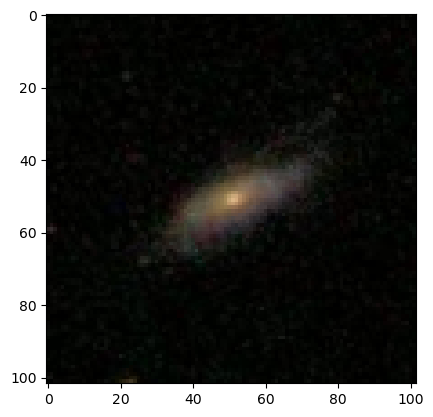

In [ ]:
entry = next(iter(testloader))
image = entry[0]
label = entry[1:]

print(len(testset))

prediction = net_t01(image.reshape(batch_size,3,image_size,image_size))

plt.imshow(image[0].permute(1,2,0).cpu().numpy())

#print(prediction.topk(1,dim=1)[1][0])

print('Guess: ' + ['smooth', 'featured', 'star'][prediction.topk(1,dim=1)[1][0].item()])
print('Label: ' + ['smooth', 'featured', 'star'][label[0][0].item()])
if prediction.topk(1,dim=1)[1][0].item() == 1:
    print('> edgeon? ' + ['yes', 'no'][label[0][1].item()])
#print('Label percentage: ' + str(label_split[0].tolist()))